# Time series

Notebook to deal with time series analysis and forecasting  
[ARIMA](#ARIMA)  
[XGBoost](#XGBoost)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.compose import ColumnTransformer

from statsmodels.api import datasets

## Read file

In [2]:
df0 = pd.read_csv("climate/DailyDelhiClimateTrain.csv")
target = 'meantemp'
endog_names = [target]
exog_names = ["humidity", "wind_speed"]#, "meanpressure"]

# df0 = datasets.nile.load_pandas().data
# target = "volume"
# endog_names = [target]
# exog_names = []

n_endog = len(endog_names)  # must be equal to 1 to use ARIMA
n_exog = len(exog_names)

df_exogeneous = df0[exog_names]  
df_endogeneous = df0[endog_names]
df = pd.concat([df_endogeneous, df_exogeneous], axis=1)

n, p = df.shape
n

1462

## Data Viz

In [3]:
df.describe()

,meantemp,humidity,wind_speed
count,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209
std,7.348103,16.769652,4.561602
min,6.000000,13.428571,0.000000
25%,18.857143,50.375000,3.475000
50%,27.714286,62.625000,6.221667
75%,31.305804,72.218750,9.238235
max,38.714286,100.000000,42.220000


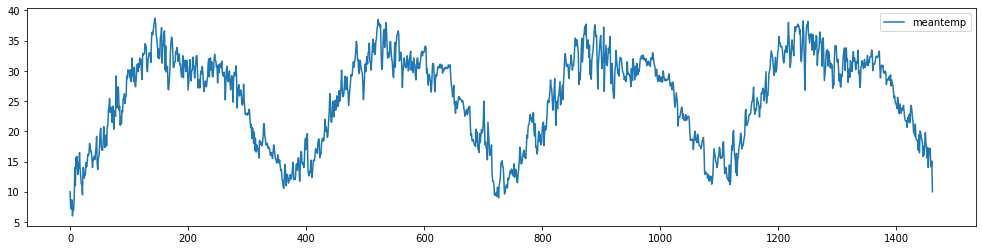

In [4]:
# Plot des variables endogènes
df[endog_names].plot(subplots=True, figsize=(17,4*n_endog));

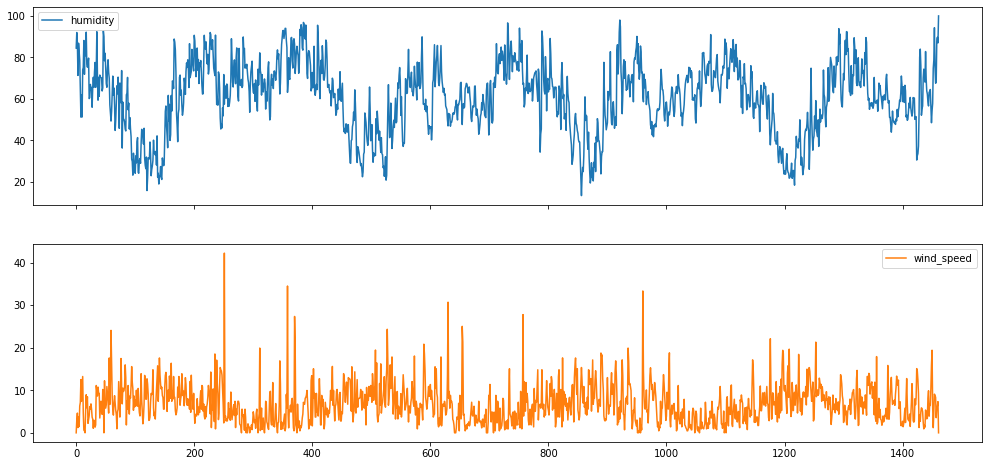

In [5]:
# Plot des variables exogènes
df[exog_names].plot(subplots=True, figsize=(17,4*n_exog));

## Split data (train, test)

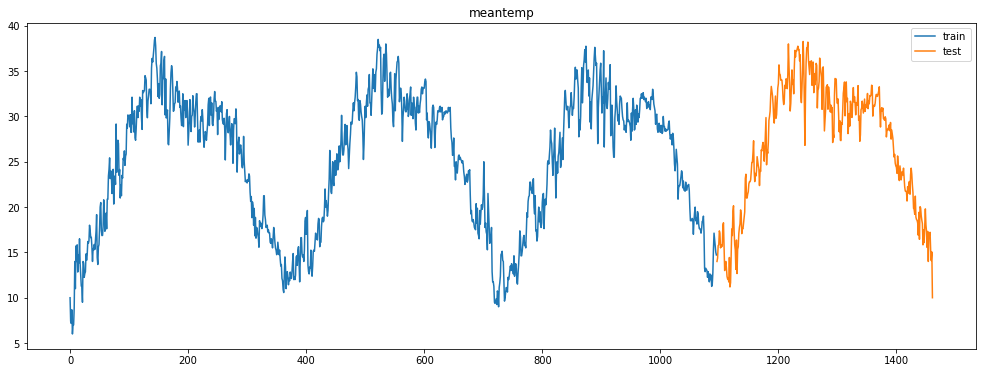

In [6]:
from sklearn.model_selection import train_test_split

per_test = 0.25
per_train = 1 - per_test

y_train, y_test = train_test_split(df, test_size=per_test, shuffle=False)

pd.concat([y_train[endog_names], y_test[endog_names]], axis=1)[target].plot(figsize=(17,6))
df_pred = y_test[[target]].rename(columns={target: "test"})

plt.title(target)
plt.legend(['train', 'test']);

## Time series decomposition 

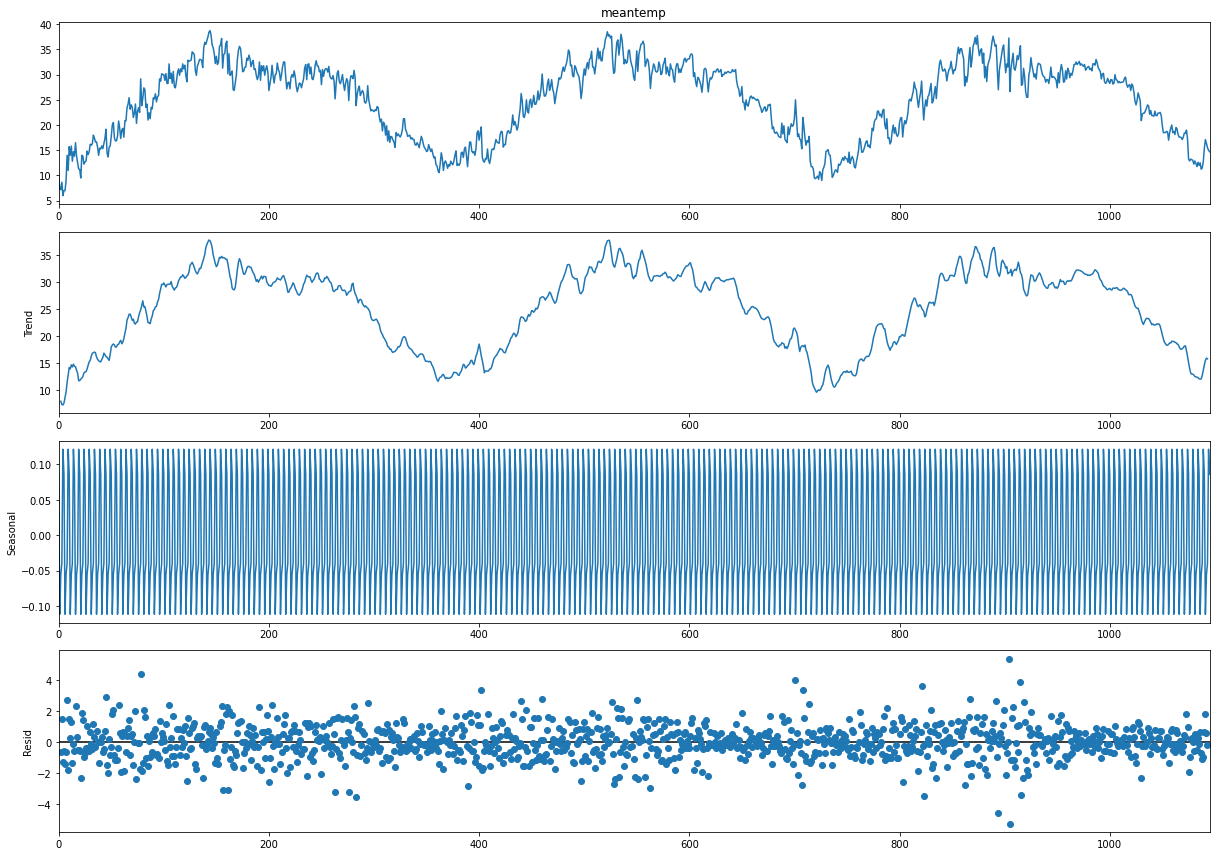

In [7]:
plt.rcParams["figure.figsize"] = (17,12)
sd = seasonal_decompose(y_train[target], period=5, model='add')
sd.plot();

mean: 0.000
std: 1.098


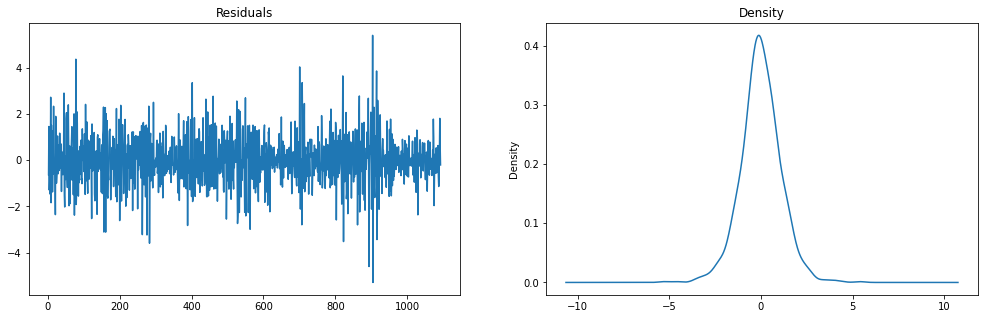

In [8]:
residuals = pd.DataFrame(sd.resid).dropna()
fig, axs = plt.subplots(1,2, figsize=(17,5))
print(f"mean: {residuals.mean()[0]:0.3f}")
print(f"std: {residuals.std()[0]:0.3f}")
residuals.plot(title="Residuals", legend=False, ax=axs[0])
residuals.plot(kind='kde', title='Density', legend=False, ax=axs[1]);

## Distributions

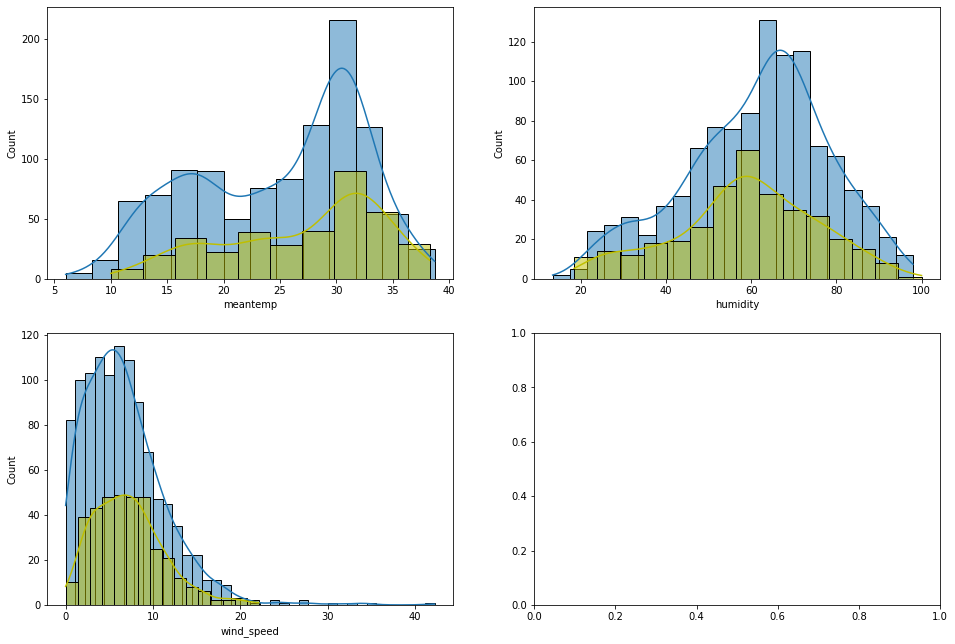

In [9]:
fig, axs = plt.subplots(p//2+1, 2, figsize=(16, 11))
sns.histplot(data=y_train, x=target, kde=True, ax=axs[0, 0])
sns.histplot(data=y_train, x=exog_names[0], kde=True, ax=axs[0, 1])
sns.histplot(data=y_train, x=exog_names[1], kde=True, ax=axs[1, 0])

sns.histplot(data=y_test, x=target, kde=True, ax=axs[0, 0], color="y")
sns.histplot(data=y_test, x=exog_names[0], kde=True, ax=axs[0, 1], color="y")
sns.histplot(data=y_test, x=exog_names[1], kde=True, ax=axs[1, 0], color="y");

# Preprocessing
Apply some transformations to endogeneous and exogeneous variables.  
Transformations are applied in two times to allow reverse transformation on the future of endogeneous variables only

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.base import clone

def preprocessing(pipe: Pipeline, y_train: pd.DataFrame, y_test: pd.DataFrame):
    """ Apply transformers to data 
    The Pipeline is fitted at the end """
    pipe_endog = pipe
    y_train_endog = pd.DataFrame(pipe_endog.fit_transform(y_train[endog_names]), index=y_train.index, columns=y_train[endog_names].columns)
    y_test_endog = pd.DataFrame(pipe_endog.transform(y_test[endog_names]), index=y_test.index, columns=y_test[endog_names].columns)

    if exog_names:
        pipe_exog = clone(pipe_endog)
        y_train_exog = pd.DataFrame(pipe_exog.fit_transform(y_train[exog_names]), index=y_train.index, columns=y_train[exog_names].columns)
        y_test_exog = pd.DataFrame(pipe_exog.transform(y_test[exog_names]), index=y_test.index, columns=y_test[exog_names].columns)
    else:
        y_train_exog = pd.DataFrame()
        y_test_exog = pd.DataFrame()

    y_train_new = pd.concat([y_train_endog, y_train_exog], axis=1).set_index(y_train_endog.index)
    y_test_new = pd.concat([y_test_endog, y_test_exog], axis=1).set_index(y_test_endog.index)
    
    return y_train_new, y_test_new

## Differenciate series

Can be used to remove seasonality if `lag` period is **T**

`lag` can be set to :
* 12 for monthly data
* ...

Can be used to compute derivative function at `order` k

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
        
class SerieDifferencier(BaseEstimator, TransformerMixin):
    """ Compute derivative and integral of an array
     
    ordre 1 : d_{t+1}=y_{t+1} - y_{t} \Leftrightarrow y_{t+k} = y_{t} + \sum_{i=1}^k d_{t+i}
    ordre 2 : d_{t+2}=y_{t+2} - 2y_{t+1} + y_{t} \Leftrightarrow y_{t+k} = ky_{t+1} - (k-1)y_{t}+ \sum_{i=2}^k (k-i+1)d_{t+i}
    """
    
    def __init__(self, lag=1, order=1):
        super(SerieDifferencier, self).__init__()
        self.lag = lag
        self.order = order
        self.initial_condition = []
    
    def derivating(self, X, y=None):
        """ Compute derivative of X """            
        is_array = isinstance(X, np.ndarray) 
        if is_array: X = pd.DataFrame(X)
        
        X = X.diff(periods=self.lag)
        
        if is_array: X = X.to_numpy()
        
        return X
        
    def integrating(self, X, x):
        """ Compute integral of X """
        if isinstance(x, pd.DataFrame):
            return X + x.shift(self.lag).values
        else:
            return X + np.roll(x, shift=self.lag, axis=0)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for i in range(1, self.order+1):
            self.initial_condition = [X] + self.initial_condition
            X = self.derivating(X)
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X, y)
        
    def inverse_transform(self, X, y=None):
        for i in range(1, self.order+1):
            X = self.integrating(X, self.initial_condition[i-1])
        return X

## Some functions

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
    
def plot_metrics(y_true, y_pred):
    metrics = eval_metrics(y_true, y_pred)
    print(f"correlation: {metrics['correlation']:.3f}")
    print(f"mape: {metrics['mape']:.2f}")
    print(f"rmse: {metrics['rmse']:.2f}")
    print(f"mae: {metrics['mae']:.2f}")
    print(f"r2: {metrics['r2']:.2f}")
    print(f"\nRMSE is {metrics['rmse_mean_per']:0.2f} % of the mean")

def eval_metrics(y_true, y_pred):
    correlation = np.corrcoef(y_true, y_pred)[0,1]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse_mean_per = rmse/y_true.mean()*100
    
    return {"correlation": correlation,
            "rmse": rmse,
            "mae": mae,
            "mape": mape,
            "r2": r2,
            "rmse_mean_per": rmse_mean_per}

# ARIMA
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html?highlight=arima#statsmodels.tsa.arima.model.ARIMA

Apply ARIMA model on data  

## Preprocessing
Let ARIMA compute derivative, do not use SerieDifferencier in the pipeline

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

pipe_arima = Pipeline([('scaler', StandardScaler()),
                       ('pt', PowerTransformer()),
                      ])

y_train_arima, y_test_arima = y_train.copy(), y_test.copy()
# y_train_arima, y_test_arima = preprocessing(pipe_arima, y_train_arima, y_test_arima)

## Coefficients research

`p` coef in **AR** term

* Keep the most significant lags (above the significance line)

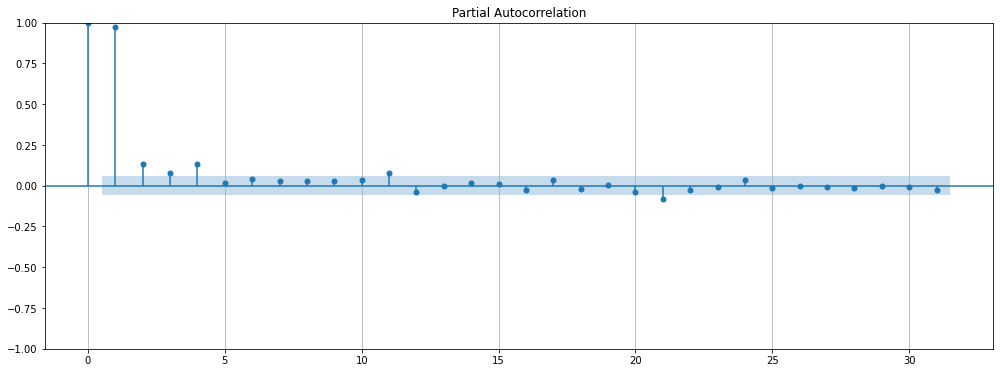

In [14]:
fig, ax = plt.subplots(1, figsize=(17,6))
ax.grid(axis='x')
ax.set_xticks(np.arange(0, 51, 5))
plot_pacf(y_train_arima[endog_names], method='ywm', ax=ax);

`d` coef in **I** term

* Differenciate the series until stationarity
* Augmented Dickey-Fuller test tests non-stationarity of the series  
$H_0$: non stationary serie  
$H_1$: stationary serie

p-value: 3.063e-01


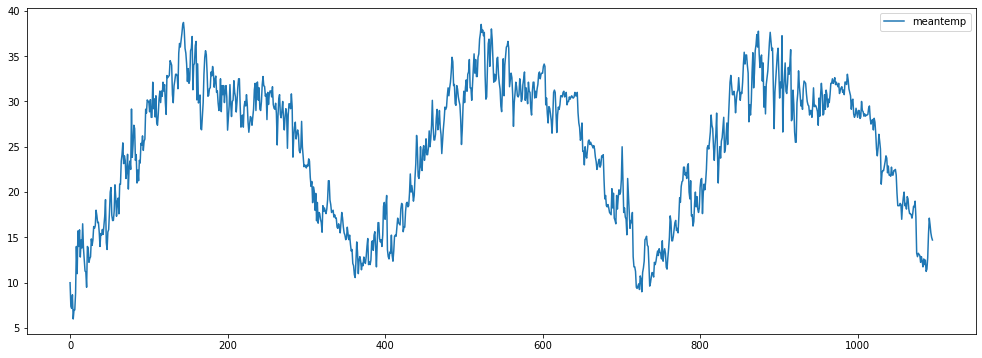

In [15]:
serie = y_train_arima[endog_names]
print(f"p-value: {adfuller(serie)[1]:.3e}")
serie.plot(figsize=(17,6));

`q` coef in **MA** term

* Keep the most significant lags (above the significance line)

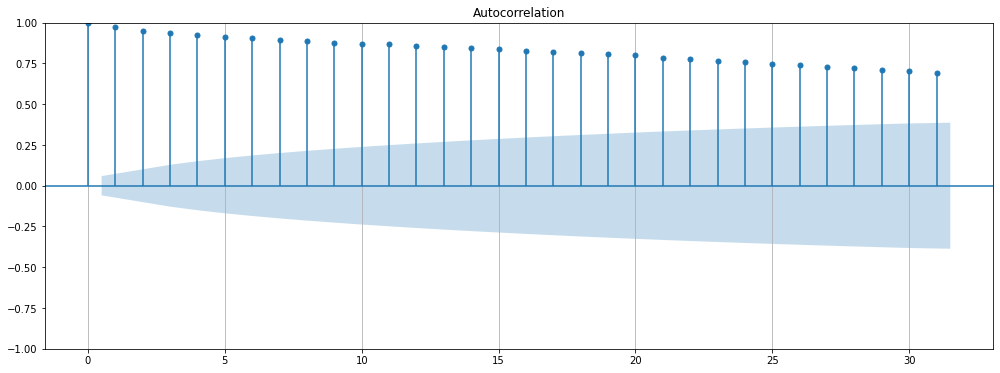

In [16]:
fig, ax = plt.subplots(1, figsize=(17,6))
ax.grid(axis='x')
ax.set_xticks(np.arange(0, 51, 5))
plot_acf(y_train_arima[endog_names], ax=ax);

### Find ARIMA coefficients  automatically

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [17]:
import pmdarima as pm

model = pm.auto_arima(y_train_arima[endog_names], 
                      X=y_train_arima[exog_names],
                      test='adf',           # use adftest to find optimal 'd'
                      start_p=0,
                      d=None,               # let model determine 'd'
                      start_q=0,
                      max_p=3,
                      max_q=3,
                      m=1,                  # frequency of series
                      seasonal=False,       # seasonality
                      start_P=0, 
                      D=None,
                      start_Q=0,
                      max_P=0,
                      max_Q=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3648.414, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3648.534, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3647.816, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3646.419, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3603.363, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3592.573, Time=0.87 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3633.537, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3592.749, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3593.904, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3594.573, Time=0.62 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3597.635, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3591.227, Time=1.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3589.018, Time=2.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3588.551, Time=1.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1096
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -1785.814
Date:                Fri, 12 Aug 2022   AIC                           3583.628
Time:                        14:59:01   BIC                           3613.619
Sample:                             0   HQIC                          3594.977
                               - 1096                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.1332      0.004    -34.075      0.000      -0.141      -0.126
wind_speed    -0.0215      0.007     -2.987      0.003      -0.036      -0.007
ma.L1         -0.0883      0.024     -3.607      0.000      -0.136      -0.040
ma.L2         -0.1570      0.025     -6.245      0.000      -0.206      -0.108
ma.L3         -0.2001      0.030     -6.682      0.000      -0.259      -0.141
sigma2         1.5276      0.046     33.369      0.000       1.438       1.617
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               427.77
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.29
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit ARIMAX

In [18]:
model = ARIMA(endog=y_train_arima[endog_names],
              exog=y_train_arima[exog_names],
              order=(2,1,2))

model_arima = model.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1096
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1788.969
Date:                Fri, 12 Aug 2022   AIC                           3591.939
Time:                        14:59:02   BIC                           3626.928
Sample:                             0   HQIC                          3605.179
                               - 1096                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.1336      0.004    -33.686      0.000      -0.141      -0.126
wind_speed    -0.0225      0.007     -3.059      0.002      -0.037      -0.008
ar.L1          0.8354      0.237      3.522      0.000       0.371       1.300
ar.L2         -0.2247      0.176     -1.276      0.202      -0.570       0.120
ma.L1         -0.9211      0.240     -3.830      0.000      -1.392      -0.450
ma.L2          0.1215      0.210      0.579      0.562      -0.290       0.533
sigma2         1.5364      0.044     35.208      0.000       1.451       1.622
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               488.11
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.29
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

correlation: 0.511
mape: 0.37
rmse: 12.53
mae: 11.03
r2: -2.29

RMSE is 46.25 % of the mean


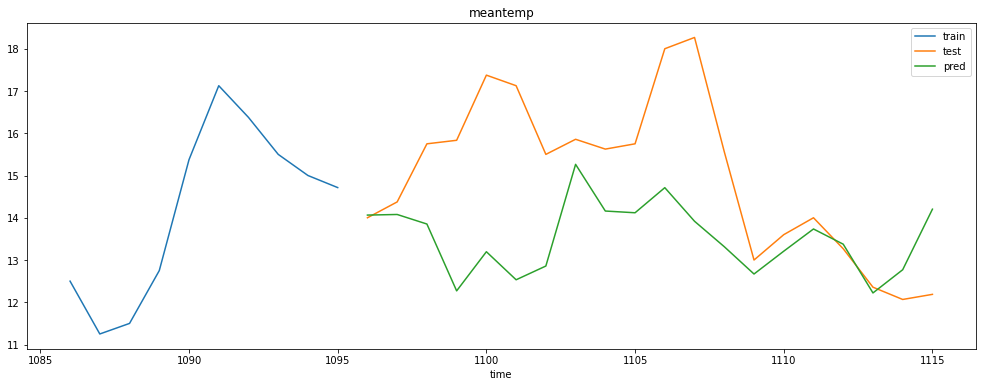

In [19]:
n0 = int(n*per_train)
step = 20
end = n0 + step
df_pred_arima = model_arima.predict(start=n0, end=n-1,
                                  exog=y_test_arima[exog_names],
                                  dynamic=False)
df_pred["arima"] = df_pred_arima
df_pred["arima_postproc"] = df_pred[["arima"]]
# df_pred["arima_postproc"] = pipe_arima.inverse_transform(df_pred[["arima"]])

plot_metrics(df_pred.dropna()["test"], df_pred.dropna()["arima_postproc"])

fig, ax = plt.subplots(1,1, figsize=(17,6))
y_train_arima[endog_names].iloc[-10:].plot(ax=ax)
y_test_arima[endog_names].iloc[:end-n0].plot(ax=ax)
df_pred_arima.iloc[:end-n0].plot(ax=ax)
plt.xlabel("time")
plt.title(target)
plt.legend(["train", "test", "pred"]);

meantemp       mean   mean_se  mean_ci_lower  mean_ci_upper
1096      14.063434  1.239523      11.634014      16.492854
1097      14.077750  1.679509      10.785972      17.369528
1098      13.851880  1.913408      10.101670      17.602090
1099      12.269943  2.058696       8.234973      16.304913
1100      13.196239  2.167193       8.948619      17.443860


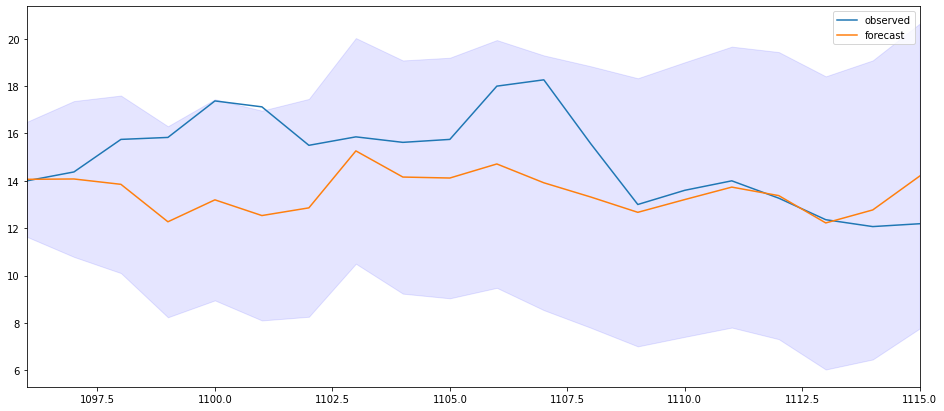

In [20]:
res = model_arima.get_forecast(step,
                               exog=y_test_arima[exog_names].iloc[:end-n0]
                              ).summary_frame(alpha=0.05)
print(res.head())

y_test_arima[endog_names][:end-n0].plot(legend=True, figsize=(16,7))
plt.plot(res["mean"])
plt.autoscale(axis='x',tight=True)
plt.fill_between(res["mean"].index, res["mean_ci_lower"], res["mean_ci_upper"], color='b', alpha=.1)
plt.legend(['observed', 'forecast']);

# XGBoost

In [21]:
from xgboost import XGBRegressor

## Preprocessing

In [22]:
lag_xgb = 2
order_xgb = 1
pipe_xgboost = Pipeline([
                        ('scaler', StandardScaler()),
                       ('pt', PowerTransformer()),
                       ('diff', SerieDifferencier(lag=lag_xgb, order=order_xgb)),
                      ])

# y_train_xgb, y_test_xgb = y_train.copy(), y_test.copy()
y_train_xgb, y_test_xgb = preprocessing(pipe_xgboost, y_train, y_test)

### Prepare data

Format data to have "supervised aspect"

In [23]:
def series_to_supervised(series: pd.DataFrame,
                         endog_names: list,
                         n_steps_in: int,
                         n_steps_out: int,
                         exog_names: list = [],
                         n_step_exog: int = 0) -> [pd.DataFrame, int, int, int]:
    """
    Format a time series as a supervised learning dataset
    @inputs:
        series: time series
        endog_names: list of names of endogeneous series
        n_steps_in: number of lag observations as input (X)
        n_steps_out: number of observations as output (y)
        endog_names: list of names of exogeneous series
        n_step_exog: number of future timestep of exogeneous variables 
    @outputs:
        dataframe of series formatted for supervised learning
    """
    
    def getXcols(cols, n_step_exog):
        return list(np.array([list(map(lambda x: x + f'(t-{i})', cols)) for i in range (n_steps_in,-n_step_exog,-1)]).flatten())
    def getYcols(cols):
        return list(np.array([list(map(lambda x: x + '(t' + f'+{i})'*(i!=0)+')'*(i==0), cols)) for i in range (0,n_steps_out)]).flatten())
    
    endog = series[endog_names]
    exog = series[exog_names]
    
    cols_endog = endog.columns
    cols_exog = exog.columns

    new_cols_x_endog = getXcols(cols_endog, n_step_exog=0)
    new_cols_y = getYcols(cols_endog)
    new_cols_x_exog = getXcols(cols_exog, n_step_exog=n_step_exog)

    n_inputs_endog = len(new_cols_x_endog)
    n_outputs_endog = len(new_cols_y)
    n_inputs_exog = len(new_cols_x_exog)
    n_features = n_outputs_endog // n_steps_out

    X_endog, X_exog, y = [], [], []
    for i in range(len(endog)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(endog):
            break
        # gather input and output parts of the pattern
        seq_x_endog, seq_y_endog = endog.iloc[i:end_ix+0, :], endog.iloc[end_ix:out_end_ix, :]
        seq_x_exog = exog.iloc[i:end_ix+n_step_exog, :]
        
        X_endog.append(seq_x_endog.to_numpy().flatten())
        X_exog.append(seq_x_exog.to_numpy().flatten())
        y.append(seq_y_endog.to_numpy().flatten())

    df_endog = pd.DataFrame(X_endog, columns=new_cols_x_endog, index=endog.index[n_steps_in+n_steps_out-1:])
    df_exog = pd.DataFrame(X_exog, columns=new_cols_x_exog, index=exog.index[n_steps_in+n_steps_out-1:])
    df_y = pd.DataFrame(y, columns=new_cols_y, index=endog.index[n_steps_in+n_steps_out-1:])
    
    return [pd.concat([df_endog, df_exog, df_y], axis=1),
            n_inputs_endog + n_inputs_exog,
            n_outputs_endog,
            n_features]

In [24]:
n_steps_in = 5
n_steps_out = 3

train_sup, n_inputs, n_outputs, n_features = series_to_supervised(y_train_xgb, endog_names, n_steps_in, n_steps_out, exog_names)
test_sup, _, _, _ = series_to_supervised(y_test_xgb, endog_names, n_steps_in, n_steps_out, exog_names)

x_train_sup, y_train_sup = train_sup.iloc[:,:-n_outputs], train_sup.iloc[:,-n_outputs:]
x_test_sup, y_test_sup = test_sup.iloc[:,:-n_outputs], test_sup.iloc[:,-n_outputs:]
test_sup

,meantemp(t-5),meantemp(t-4),meantemp(t-3),meantemp(t-2),meantemp(t-1),humidity(t-5),wind_speed(t-5),humidity(t-4),wind_speed(t-4),humidity(t-3),wind_speed(t-3),humidity(t-2),wind_speed(t-2),humidity(t-1),wind_speed(t-1),meantemp(t),meantemp(t+1),meantemp(t+2)
1103,NaN,NaN,0.169390,0.141917,0.163997,NaN,NaN,NaN,NaN,0.088823,-0.809015,1.039431,-1.534668,0.326825,0.889838,0.130062,-0.188630,-0.127703
1104,NaN,0.169390,0.141917,0.163997,0.130062,NaN,NaN,0.088823,-0.809015,1.039431,-1.534668,0.326825,0.889838,-0.140823,-0.249888,-0.188630,-0.127703,0.012298
1105,0.169390,0.141917,0.163997,0.130062,-0.188630,0.088823,-0.809015,1.039431,-1.534668,0.326825,0.889838,-0.140823,-0.249888,0.120597,1.560469,-0.127703,0.012298,-0.010604
1106,0.141917,0.163997,0.130062,-0.188630,-0.127703,1.039431,-1.534668,0.326825,0.889838,-0.140823,-0.249888,0.120597,1.560469,-1.541706,2.564566,0.012298,-0.010604,0.241339
1107,0.163997,0.130062,-0.188630,-0.127703,0.012298,0.326825,0.889838,-0.140823,-0.249888,0.120597,1.560469,-1.541706,2.564566,-0.641642,-1.398365,-0.010604,0.241339,0.257094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.020210,-0.268257,-0.253973,0.003341,-0.149672,-0.100026,1.120577,0.509502,-1.580263,1.280308,-3.543589,1.360137,-0.248932,1.471536,2.197851,-0.018007,0.279638,0.007644
1458,-0.268257,-0.253973,0.003341,-0.149672,-0.018007,0.509502,-1.580263,1.280308,-3.543589,1.360137,-0.248932,1.471536,2.197851,-0.269046,0.803917,0.279638,0.007644,-0.160526
1459,-0.253973,0.003341,-0.149672,-0.018007,0.279638,1.280308,-3.543589,1.360137,-0.248932,1.471536,2.197851,-0.269046,0.803917,-1.956005,-0.139231,0.007644,-0.160526,-0.308128
1460,0.003341,-0.149672,-0.018007,0.279638,0.007644,1.360137,-0.248932,1.471536,2.197851,-0.269046,0.803917,-1.956005,-0.139231,-0.463146,-1.312598,-0.160526,-0.308128,-0.018063


## Fit XGBoost

In [25]:
%%time
model_xgb = XGBRegressor(objective='reg:squarederror',
                         n_estimators=100,
                         n_jobs=16)

model_xgb.fit(x_train_sup, y_train_sup)

CPU times: user 13.3 s, sys: 21.1 ms, total: 13.3 s
Wall time: 901 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=16, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Test
Use auto-regression on test values to predict future values

In [26]:
def get_pred(model, x_test, y_test):
    y_pred_sup = np.atleast_2d(model.predict(x_test))
    df_y_pred = pd.Series(format_y(y_pred_sup).ravel(), index=y_test.index[n_steps_in:])
    return df_y_pred

def format_y(y: np.array) -> np.array:
    """ get first row and last column the recover y_test """
    return np.concatenate((y[0,:-n_endog], y[:,-n_endog:].ravel())).reshape(-1,1)
format_y(y_test_sup.to_numpy()).shape

(361, 1)

correlation: 0.934
mape: 0.08
rmse: 2.48
mae: 1.89
r2: 0.87

RMSE is 9.09 % of the mean


/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


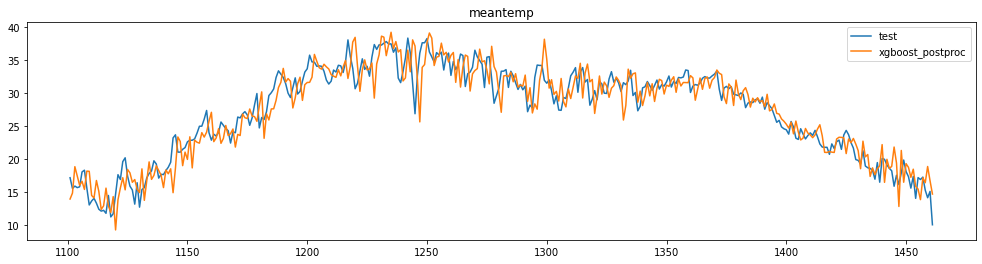

In [27]:
df_pred["xgboost"] = get_pred(model_xgb, x_test_sup, y_test)
df_pred["xgboost_postproc"] = pipe_xgboost.inverse_transform(df_pred[["xgboost"]])

plot_metrics(df_pred.dropna()["test"], df_pred.dropna()["xgboost_postproc"])
df_pred.dropna()[["test", "xgboost_postproc"]].plot(figsize=(17,4), title=target);

## Train at each time step
Train the model regularly to update it with the new data

In [28]:
import tqdm
from sklearn.model_selection import TimeSeriesSplit

def refit_at_each_time_step(model):
    df_pred_refit = pd.DataFrame([], columns=["refit"], index=df_pred.index)
        
    tscv = TimeSeriesSplit(n_splits=3, test_size=30, gap=0)
    for train_index, test_index in tqdm.tqdm(tscv.split(df), total=tscv.get_n_splits()):
        y_train_refit = df.iloc[train_index]
        y_test_refit = df.iloc[test_index]
        
        df_pred_refit_tmp = y_test_refit[[target]].rename(columns={target: "test"})
        
        y_train_xgb_refit, y_test_xgb_refit = preprocessing(pipe_xgboost, y_train_refit, y_test_refit)

        train_sup_refit, n_inputs, n_outputs, n_features = series_to_supervised(y_train_xgb_refit, endog_names, n_steps_in, n_steps_out, exog_names)
        test_sup_refit, _, _, _ = series_to_supervised(y_test_xgb_refit, endog_names, n_steps_in, n_steps_out, exog_names)

        x_train_sup_refit, y_train_sup_refit = train_sup_refit.iloc[:,:-n_outputs], train_sup_refit.iloc[:,-n_outputs:]
        x_test_sup_refit, y_test_sup_refit = test_sup_refit.iloc[:,:-n_outputs], test_sup_refit.iloc[:,-n_outputs:]

        model_refit = model
        model_refit.fit(x_train_sup_refit, y_train_sup_refit)

        df_pred_refit_tmp["xgboost_refit"] = get_pred(model_refit, x_test_sup_refit, y_test_refit)
        df_pred_refit.loc[y_test_refit.index, ["refit"]] = pipe_xgboost.inverse_transform(df_pred_refit_tmp[["xgboost_refit"]])

    df_pred_refit = df_pred_refit.astype(np.float64)
    return df_pred_refit

df_pred["xgboost_refit_postproc"] = refit_at_each_time_step(XGBRegressor())

  0%|                                                     | 0/3 [00:00<?, ?it/s]/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
 33%|███████████████                              | 1/3 [00:04<00:09,  4.83s/it]/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
 67%|██████████████████████████████               | 2/3 [00:06<00:03,  3.22s/it]/data/appli_PITSI/users/targe/miniconda3/envs/dev3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.86s/it]


correlation: 0.924
mape: 0.08
rmse: 2.00
mae: 1.49
r2: 0.83

RMSE is 8.94 % of the mean


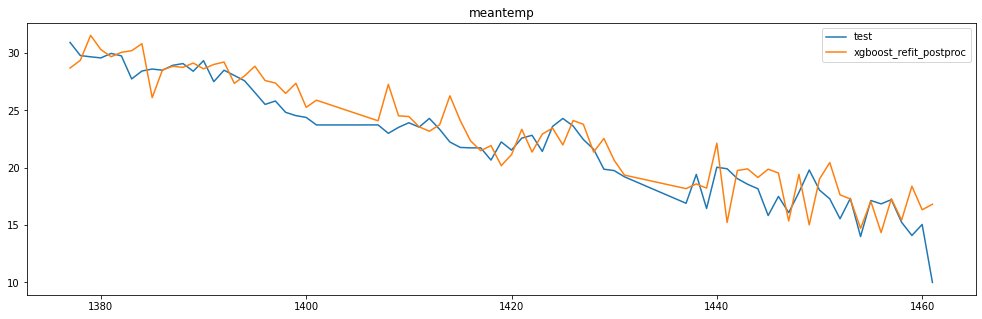

In [29]:
plot_metrics(df_pred.dropna()["test"], df_pred.dropna()["xgboost_refit_postproc"])

df_pred[["test", "xgboost_refit_postproc"]].dropna().iloc[:].plot(figsize=(17,5), title=target);

## Features importance

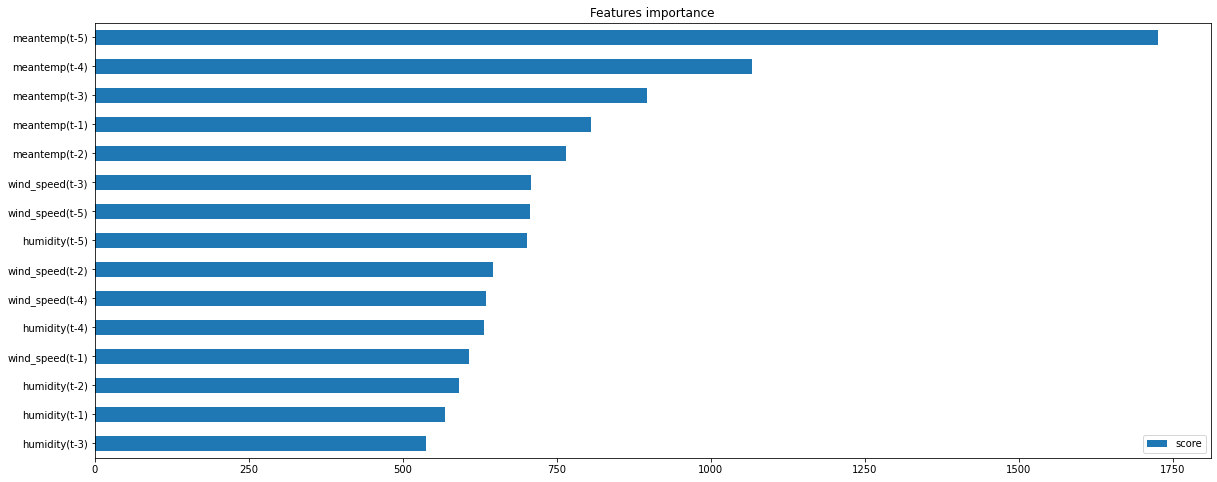

In [30]:
feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)
data.plot(kind='barh', figsize=(20,8), title="Features importance");

## Forecasting with predictions 
Use auto-regression on predictions to predict future values

In [31]:
days_to_pred = 50
def get_pred_autoregressivly(model, df: pd.DataFrame):
    preds = []
    for i in df.index:
        pred = model.predict(df.loc[[i],:])[0][0]
        preds.append(pred)
        if len(preds) != days_to_pred:
            df.loc[i+1, target + "(t-1)"] = pred
        else:
            break
    return preds

preds = get_pred_autoregressivly(model_xgb, x_test_sup)

# Models comparison

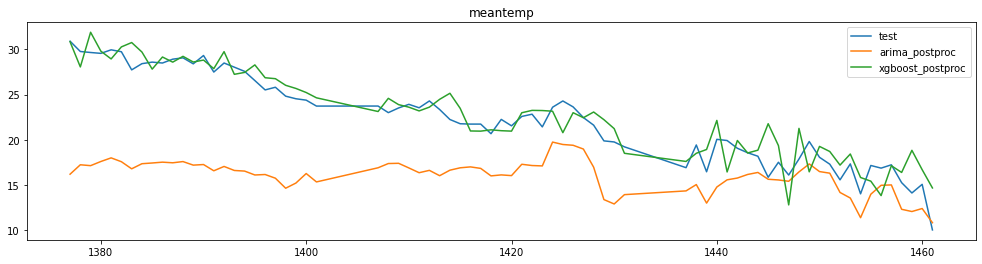

In [32]:
df_pred.dropna()[["test", "arima_postproc", "xgboost_postproc"]].iloc[:].plot(figsize=(17,4), title=target);